In [ ]:
# 1. A perceptron is a supervised learning algorithm and binary classifier. It uses weights on the input variables and can have multiple layers.

# 2. There are single and multilayer perceptrons. A multilayer perceptron puts each input variable through multiple weights before giving an output. A single layer perceptron puts each variable through only one weight. 

# 3. A hard margin is a model with zero errors.

# 4. d. all the above

# 5. a. Kernel function map low dimensional data into high dimensional space. 

In [1]:
import boto3
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'ryan-greiner-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'framingham.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading CSV file
heart = pd.read_csv(file_content_stream)
heart = heart.dropna()
heart.head()

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [2]:
X = heart[['age', 'currentSmoker', 'totChol', 'BMI', 'heartRate']]
Y = heart['TenYearCHD']

In [ ]:
# Store Results
percep1_recall = list()
percep2_recall = list()
svm1_recall = list()
svm2_recall = list()

for i in range(0, 100):
    # Split and scale data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
    
    # First Perceptron Model
    percep_md1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, input_dim = 5, activation = 'tanh'),
        tf.keras.layers.Dense(2, activation = 'softmax')])
    
    percep_md1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    percep_md1.fit(X_train,
              tf.keras.utils.to_categorical(Y_train, num_classes = 2),
              epochs = 100,
              batch_size = 500,
              validation_data = (X_test, tf.keras.utils.to_categorical(Y_test, num_classes = 2)))
    
    percep_pred1 = percep_md1.predict(X_test)
    percep_label1 = np.where(percep_pred1 < .15, 0, 1)[:, 1]
    percep1_recall.append(recall_score(Y_test, percep_label1))
    
    # Second Perceptron Model
    percep_md2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, input_dim = 5, activation = 'relu'),
        tf.keras.layers.Dense(2, activation = 'softmax')])
    
    percep_md2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    percep_md2.fit(X_train,
              tf.keras.utils.to_categorical(Y_train, num_classes = 2),
              epochs = 100,
              batch_size = 500,
              validation_data = (X_test, tf.keras.utils.to_categorical(Y_test, num_classes = 2)))
    
    percep_pred2 = percep_md2.predict(X_test)
    percep_label2 = np.where(percep_pred2 < .15, 0, 1)[:, 1]
    percep2_recall.append(recall_score(Y_test, percep_label2))
    
    # First Support Vector Machine
    svm_md1 = SVC(kernel = 'rbf', probability = True).fit(X_train, Y_train)
    svm_pred1 = svm_md1.predict_proba(X_test)[:, 1]
    svm_label1 = np.where(svm_pred1 < .15, 0, 1)
    svm1_recall.append(recall_score(Y_test, svm_label1))
    
    # Second Support Vector Machine
    svm_md2 = SVC(kernel = 'poly', probability = True).fit(X_train, Y_train)
    svm_pred2 = svm_md2.predict_proba(X_test)[:, 1]
    svm_label2 = np.where(svm_pred2 < .15, 0, 1)
    svm2_recall.append(recall_score(Y_test, svm_label2))

Epoch 1/100
6/6 [==============================] - 0s 30ms/step - loss: 0.6845 - accuracy: 0.5441 - val_loss: 0.6598 - val_accuracy: 0.6489
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.7363 - val_loss: 0.6163 - val_accuracy: 0.7869
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5958 - accuracy: 0.8311 - val_loss: 0.5825 - val_accuracy: 0.8361
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5656 - accuracy: 0.8461 - val_loss: 0.5561 - val_accuracy: 0.8456
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5419 - accuracy: 0.8478 - val_loss: 0.5354 - val_accuracy: 0.8456
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5233 - accuracy: 0.8478 - val_loss: 0.5191 - val_accuracy: 0.8470
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5085 - accuracy: 0.8478 - val_loss: 0.5059 - val_accuracy: 0.8470
Epoch 8/100
6/6 [=========

Matplotlib is building the font cache; this may take a moment.


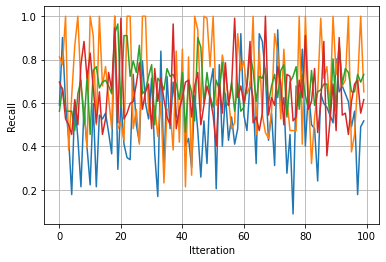

In [4]:
import matplotlib.pyplot as plt

plt.plot(percep1_recall)
plt.plot(percep2_recall)
plt.plot(svm1_recall)
plt.plot(svm2_recall)
plt.xlabel('Itteration')
plt.ylabel('Recall')
plt.grid()
plt.show();

In [7]:
import statistics
print('First Perceptron Model =', statistics.mean(percep1_recall))
print('Second Perceptron Model =', statistics.mean(percep2_recall))
print('First Support Vector Machine', statistics.mean(svm1_recall))
print('Second Support Vector Machine', statistics.mean(svm2_recall))

First Perceptron Model = 0.5299107142857142
Second Perceptron Model = 0.6853571428571429
First Support Vector Machine 0.6836607142857143
Second Support Vector Machine 0.6388392857142857


In [ ]:
# The best Model is the Perceptron model using ReLu as the activation function